# Conv1D Autoencoder를 사용한 시계열 data 이상 감지
시계열 자료의 이상치 검출

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, Dropout, Conv1DTranspose
from matplotlib import pyplot as plt

## Load the data

비정상적인 동작 기간이 labeling 된  인공 시계열 데이터
[Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) 를 사용합니다. 데이터는 정열되고 타임스탬프가 지정된 단일 값 메트릭입니다.

학습에는 noise가 포함된 정상 시계열 데이터인인 `art_daily_small_noise.csv` 파일을 사용하고 테스트에는 이상치가 포함된 `art_daily_jumpsup.csv` 파일을 사용합니다. 이 데이터 세트의 단순성 덕분에 이상 탐지를 효과적으로 시연할 수 있습니다.

In [6]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

# Train set
df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

# Test set
df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

print(df_small_noise.shape, df_daily_jumpsup.shape)

(4032, 1) (4032, 1)


In [7]:
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [8]:
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


## data 시각화
### noise 가 포함된 정상 시계열 데이터

- 정상 데이터를 autoencoder 훈련에 사용합니다.

<AxesSubplot:xlabel='timestamp'>

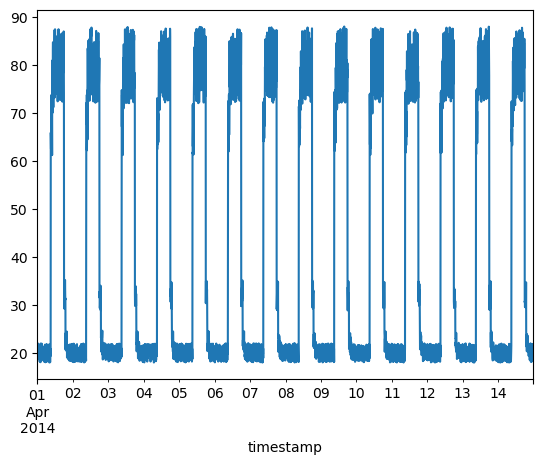

In [9]:
df_small_noise.plot(legend=False)

### 이상치가 있는 시계열 데이터

정상 데이터로 훈련된 autoencoder 모델의 테스트를 위해 다음 데이터를 사용하고, 데이터의 갑작스러운 점프가 이상으로 감지되는지 확인합니다.

<AxesSubplot:xlabel='timestamp'>

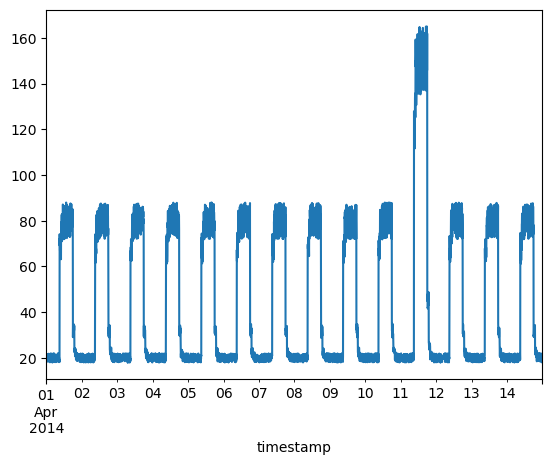

In [10]:
df_daily_jumpsup.plot(legend=False)

## 훈련 데이터 준비

훈련 시계열 데이터 파일(`df_small_noise`)에서 데이터 값을 가져오고 `value` 데이터를 정규화 합니다. 14일 동안 5분마다 `value`가 있습니다.

-   24일 * 60분 / 5분 = **288 timesteps per day**
-   288 timesteps per day * 14일 = **total 4032 data points** 

In [11]:
# 테스트 데이터를 정규화하기 위해 평균과 표준 편차를 정규화하고 저장합니다.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()

# standard scaling
df_training_value = (df_small_noise - training_mean) / training_std

print("훈련 샘플 수:", len(df_training_value))

훈련 샘플 수: 4032


In [12]:
# normalize된 df_small_noise
df_training_value.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


### 시퀀스 data 생성

훈련 데이터에서 `TIME_STEPS` 연속 데이터 값을 조합하여 시퀀스를 생성합니다.

In [13]:
TIME_STEPS = 288

# 모델에서 사용하기 위해 생성된 훈련 시퀀스
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

X_train = create_sequences(df_training_value.values)
print("Training input shape: ", X_train.shape)

Training input shape:  (3745, 288, 1)


## Build a model

컨볼루션 재구성 오토인코더 모델을 구축합니다. 모델은 `(batch_size, sequence_length, num_features)`  shape의 입력을 받고 동일한 shape의 출력을 반환합니다. 이 경우 `sequence_length`는 288이고 `num_features`는 1입니다.

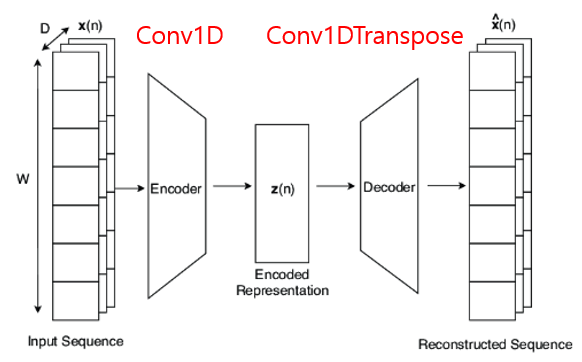

In [14]:
X_train.shape[1], X_train.shape[2]

(288, 1)

In [15]:
model = keras.Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Conv1D(filters=32, kernel_size=7, padding="same", 
               strides=2, activation="relu"),
        Dropout(rate=0.2),
        Conv1D(filters=16, kernel_size=7, padding="same", 
               strides=2, activation="relu"),
        Dropout(rate=0.2),
        Conv1DTranspose(filters=16, kernel_size=7, padding="same", 
                        strides=2, activation="relu"),
        Conv1DTranspose(filters=32, kernel_size=7, padding="same", 
                        strides=2, activation="relu"),
        Conv1DTranspose(filters=1, kernel_size=1, padding="same"),
    ])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 dropout_1 (Dropout)         (None, 72, 16)            0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

## 모델 train

재구성 모델이기 때문에 Input과 Target 모두 `X_train`을 사용합니다.

In [16]:
history = model.fit(
    X_train, X_train,
    epochs=50, batch_size=128, validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ]
)

Epoch 1/50
27/27 [==============================] - 2s 34ms/step - loss: 0.7095 - val_loss: 0.3865
Epoch 2/50
27/27 [==============================] - 1s 28ms/step - loss: 0.1343 - val_loss: 0.0588
Epoch 3/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0577 - val_loss: 0.0384
Epoch 4/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0477 - val_loss: 0.0338
Epoch 5/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0416 - val_loss: 0.0306
Epoch 6/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0366 - val_loss: 0.0309
Epoch 7/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0332 - val_loss: 0.0289
Epoch 8/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0304 - val_loss: 0.0296
Epoch 9/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0281 - val_loss: 0.0283
Epoch 10/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0264 - val_loss: 0.0295
Epoch 11/

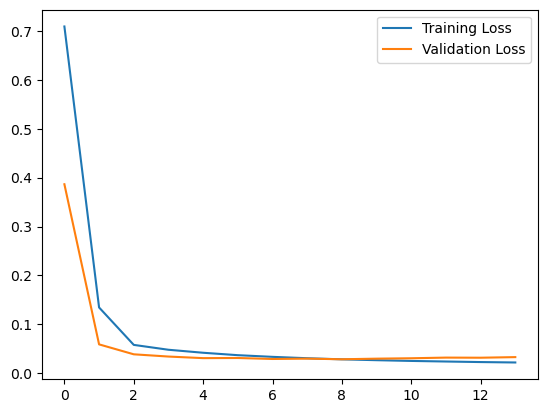

In [17]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## 이상 감지

모델이 입력 데이터를 얼마나 잘 재구성할 수 있는지 결정하여 이상을 감지합니다.

1.   훈련 샘플에서 MAE 손실을 찾습니다.
2.   최대 MAE 손실 값을 찾습니다. 이것은 우리 모델이 샘플을 재구성하기 위해 수행한 최악의 작업입니다. 이를 이상 감지의 `threshold`로 설정합니다.
3.   샘플의 재구성 손실이 이 `threshold` 보다 크면 모델이 익숙하지 않은 패턴을 보고 있다고 추론할 수 있습니다. 우리는 이 샘플을 `anomaly`로 분류할 것입니다.

- MAE 손실 시각화

118/118 [==============================] - 1s 4ms/step


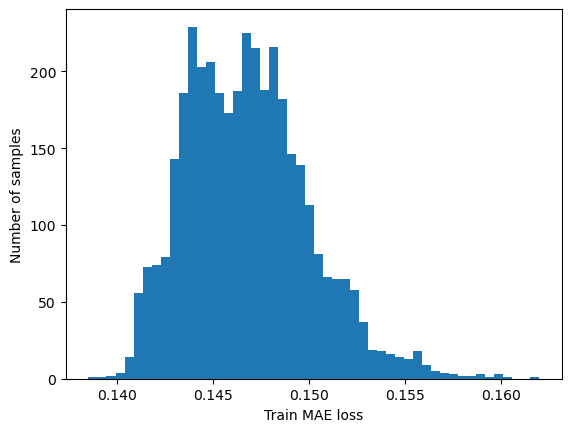

In [18]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("Number of samples")
plt.show()

- train set의 최대 MAE 손실을 재구성 손실 임계값으로 정합니다.

In [19]:
threshold = np.max(train_mae_loss)
print("재구성 오류 임계값: ", threshold)

재구성 오류 임계값:  0.16197999241939723


### 재구성 비교

우리 모델이 첫 번째 샘플을 어떻게 재구성했는지 봅니다.
이것은 훈련 데이터 세트 1일차의 288개 timestep 입니다.

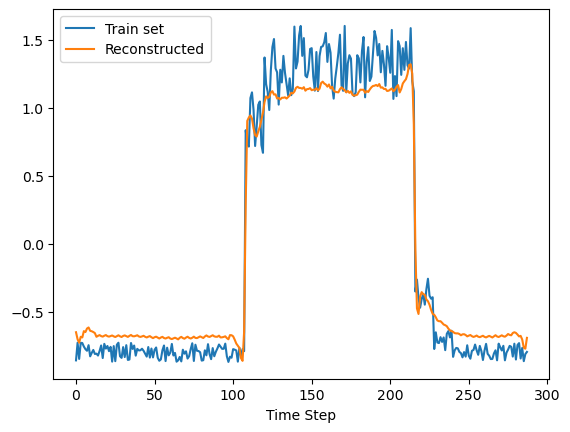

In [20]:
# 첫 번째 시퀀스가  어떻게 학습되었는지 확인
plt.plot(X_train[0], label='Train set')
plt.plot(X_train_pred[0], label='Reconstructed')
plt.xlabel("Time Step")
plt.legend()

### 테스트 데이터 준비
- Test set을 standard scale   
- 분포가 바뀌면 안되므로 Train set 에서 구해 놓았던 평균과 표준 편차를 그대로 사용
- 시각화

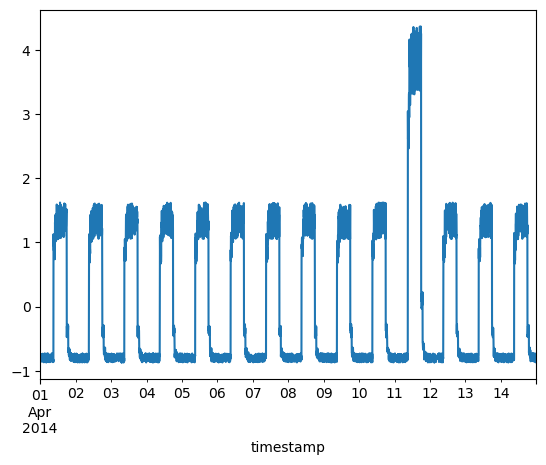

In [21]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

- Test set에서 시계열 시퀀스 data 생성

In [22]:
X_test = create_sequences(df_test_value.values)
print("Test input shape: ", X_test.shape)

Test input shape:  (3745, 288, 1)


- Test set의 MAE loss 구하기

In [23]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

118/118 [==============================] - 1s 4ms/step


- MAE 손실 시각화

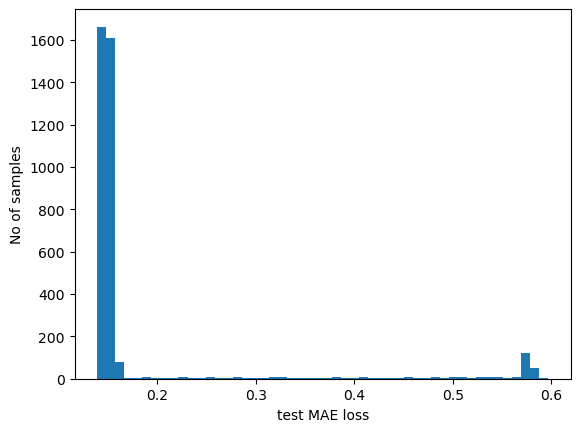

In [24]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

- 모든 이상 샘플 감지  
- train set의 최대 MAE 손실에서 구했던 threshold 사용

In [25]:
threshold

0.16197999241939723

In [30]:
anomalies = test_mae_loss > threshold  
anomalies

array([False, False, False, ..., False, False, False])

In [31]:
print("이상 감지된 샘플 수: ", np.sum(anomalies))
print("이상 감지된 샘플의 인덱스: ", np.where(anomalies))

이상 감지된 샘플 수:  402
이상 감지된 샘플의 인덱스:  (array([ 787,  967,  969, 1651, 2523, 2695, 2697, 2701, 2702, 2703, 2704,
       2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715,
       2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726,
       2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737,
       2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748,
       2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759,
       2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770,
       2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781,
       2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792,
       2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803,
       2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814,
       2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825,
       2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836,
       2837, 28

## 이상치 plot

이제 우리는 비정상 데이터 샘플을 알고 있습니다. 이를 통해 원본 테스트 데이터에서 해당 `timestamps`를 찾을 수 있습니다. 이를 위해 다음 방법을 사용할 것입니다.

time_steps = 3이고 10개의 훈련 값이 있다고 가정해 보겠습니다. 우리의 `X_train`은 다음과 같이 보일 것입니다:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

초기 및 마지막 time_steps-1 데이터 값을 제외한 모든 값은 `time_steps` 샘플 수로 표시됩니다. 따라서 샘플 [(3, 4, 5), (4, 5, 6), (5, 6, 7)]이 비정상이라는 것을 안다면 데이터 포인트 5가 비정상이라고 말할 수 있습니다.  

그러므로 `TIME_STEPS`기간 전체 샘플 `[(i - timesteps + 1) ~ (i)]`이 비정상인 경우 데이터 `i`는 비정상으로 분류할 수 있습니다.

In [27]:
TIME_STEPS

288

In [29]:
anomalies

array([False, False, False, ..., False, False, False])

np.all() 함수는 주어진 배열 내의 모든 요소가 True일 경우에만 True를 반환합니다. 따라서 다음 코드는 범위 내의 모든 요소가 True(이상치)인지를 확인

In [28]:
index = 2754
np.all(anomalies[index: index+TIME_STEPS])  # index => 비정상

True

- for 루프를 통해 시계열 데이터를 반복합니다. 반복은 TIME_STEPS - 1부터 시작하며, len(df_test_value) - TIME_STEPS + 1에서 끝납니다.  
- 각 반복에서, np.all() 함수를 사용하여 anomalies 배열의 연속된 시간 단계가 모두 True인지(즉, 모두 이상치인지) 확인합니다. 이 때 범위는 data_idx - TIME_STEPS + 1에서 data_idx까지입니다.  
- 만약 모든 시간 단계가 이상치라면(np.all() 함수의 결과가 True), 해당 시간 단계의 마지막 인덱스 data_idx를 anomalous_data_indices 리스트에 추가합니다.

In [36]:
anomalous_data_indices = []

for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [37]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
df_subset.head()

,value
timestamp,
2014-04-11 09:00:00,127.882020
2014-04-11 09:05:00,115.705719
2014-04-11 09:10:00,122.386410
2014-04-11 09:15:00,127.261178
2014-04-11 09:20:00,121.157997


원본 테스트 데이터 플롯에 모델이 탐지한 이상치를 오버레이해 시각화

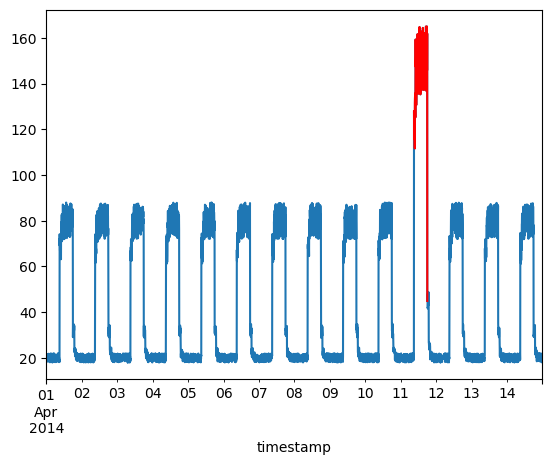

In [39]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()